In [2]:
import itertools
import os
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import random

# matplotlib.use('TkAgg')
%matplotlib inline

warnings.simplefilter('ignore')

In [14]:
def readNetGML(path):
    graph = nx.Graph()
    
    with open(path, 'r') as f:
        lines = f.readlines()

    nodes = set()
    edges = set()
    inside_edge_block = False
    source = None
    target = None

    for line in lines:
        if line.strip().startswith("node"):
            inside_edge_block = False
        elif line.strip().startswith("edge"):
            inside_edge_block = True
            source = None
            target = None
        elif inside_edge_block:
            if "source" in line:
                source = int(line.split()[-1])
                nodes.add(source)
            elif "target" in line:
                target = int(line.split()[-1])
                nodes.add(target)
            if source is not None and target is not None:
                if (source, target) not in edges and (target, source) not in edges:
                    edges.add((source, target))

    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    return graph

# Fitness function: modularity
def modularity(G, communities):
    return nx.algorithms.community.quality.modularity(G, communities)

# Generate initial population
def initial_population(G, population_size):
    population = []
    for _ in range(population_size):
        individual = {node: random.randint(0, len(G.nodes()) - 1) for node in G.nodes()}
        population.append(individual)
    return population

# Convert individual to community structure
def individual_to_communities(individual):
    communities = {}
    for node, community in individual.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)
    return list(communities.values())

# Selection: Tournament selection
def tournament_selection(population, fitnesses, k=5):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

# Crossover: Community-based crossover
def crossover(parent1, parent2):
    child = parent1.copy()
    for node in child:
        if random.random() > 0.5:
            child[node] = parent2[node]
    return child

# Mutation: Random reassign node to a different community
def mutate(individual, mutation_rate):
    for node in individual:
        if random.random() < mutation_rate:
            individual[node] = random.randint(0, len(individual) - 1)
    return individual

# Local search for refining community structure
def local_search(individual, G):
    best_individual = individual.copy()
    best_modularity = modularity(G, individual_to_communities(individual))
    
    for node in individual:
        current_community = individual[node]
        best_community = current_community
        
        for neighbor in G.neighbors(node):
            individual[node] = individual[neighbor]
            new_modularity = modularity(G, individual_to_communities(individual))
            if new_modularity > best_modularity:
                best_modularity = new_modularity
                best_community = individual[neighbor]
        
        individual[node] = best_community
    
    return individual

def plotNetwork(graph):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(graph, pos, node_size=600, cmap='plasma')
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    plt.title("The network graph")
    plt.show()

def plotCommunities(graph, pos, communities):
    node_to_community = {}
    for community_index, community in enumerate(communities):
        for node in community:
            node_to_community[node] = community_index

    node_colors = [node_to_community[node] for node in graph.nodes()]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(graph, pos, node_size=600, cmap='plasma', node_color=node_colors)
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    plt.title("Visualising the communities from the network")
    plt.show()

# Genetic algorithm for community detection with stopping criterion
def genetic_algorithm_community_detection(G, population_size=100, generations=5, mutation_rate=0.05, elitism_rate=0.1, patience=5):
    population = initial_population(G, population_size)
    best_individual = None
    best_fitness = -float('inf')
    
    no_improvement_generations = 0
    
    for generation in range(generations):
        fitnesses = [modularity(G, individual_to_communities(ind)) for ind in population]
        
        new_population = []
        elite_count = int(elitism_rate * population_size)
        
        # Add the best individuals to the new population (elitism)
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)[:elite_count]
        for i in elite_indices:
            new_population.append(population[i])
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            # child = local_search(child, G)
            new_population.append(child)
        
        population = new_population
        
        # Find the best individual in the current generation
        current_best_fitness = -float('inf')
        for ind, fit in zip(population, fitnesses):
            if fit > current_best_fitness:
                current_best_fitness = fit
                current_best_individual = ind
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual
            no_improvement_generations = 0
        else:
            no_improvement_generations += 1

        print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")

        if no_improvement_generations >= patience:
            print("No improvement for 10 generations. Stopping early.")
            break
    
    return best_individual, best_fitness

The current graph is:  Graph with 62 nodes and 159 edges


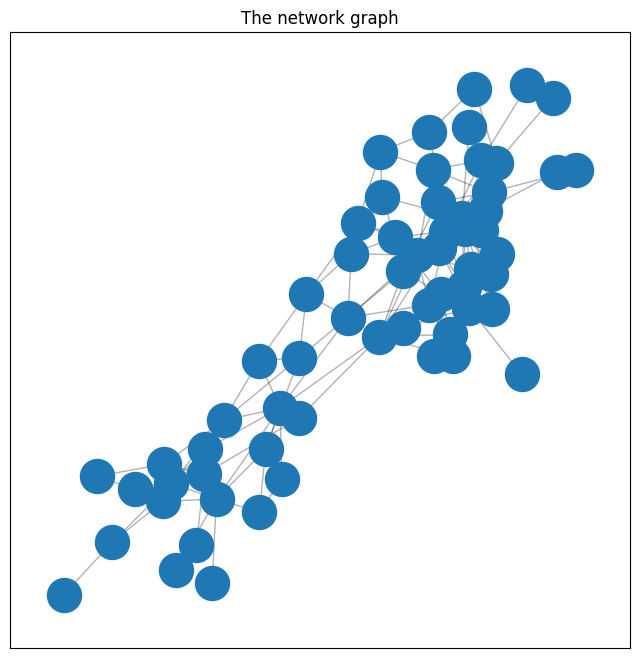

Generation 1, Best Fitness: -0.0008899964400142491
Generation 2, Best Fitness: 0.421423203196076
Generation 3, Best Fitness: 0.4914164787785293
Generation 4, Best Fitness: 0.5017997705786954
Generation 5, Best Fitness: 0.5017997705786954
Generation 6, Best Fitness: 0.5104624025948341
Generation 7, Best Fitness: 0.5104624025948341
Generation 8, Best Fitness: 0.5104624025948341
Generation 9, Best Fitness: 0.5104624025948341
Generation 10, Best Fitness: 0.5104624025948341


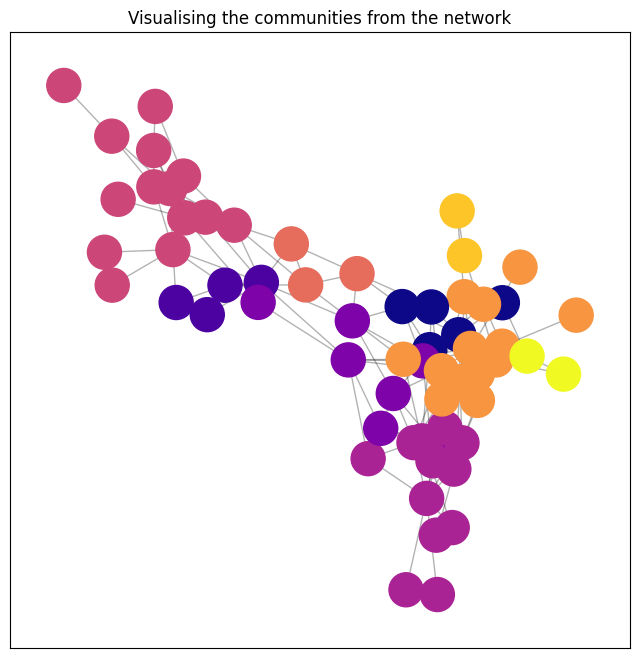

Best partition: [[0, 2, 10, 42, 47], [1, 25, 26, 27], [3, 8, 20, 28, 36, 39, 59], [4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55], [5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60], [7, 19, 30], [12, 14, 16, 33, 34, 37, 38, 40, 43, 44, 50, 52, 58], [46, 49], [53, 61]]
Best modularity: 0.5104624025948341
-----------------------------------------------------------------------------------------------------------------------------------------------
The current graph is:  Graph with 115 nodes and 613 edges


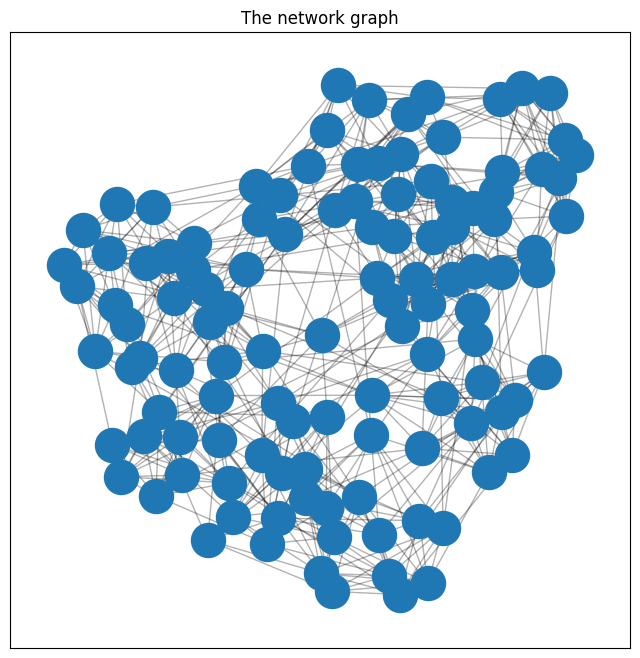

Generation 1, Best Fitness: 0.00168853737269439
Generation 2, Best Fitness: 0.5428694224377208
Generation 3, Best Fitness: 0.6010088644885554
Generation 4, Best Fitness: 0.60320436225447
Generation 5, Best Fitness: 0.60320436225447
Generation 6, Best Fitness: 0.60320436225447
Generation 7, Best Fitness: 0.60320436225447
Generation 8, Best Fitness: 0.6045695626834571
Generation 9, Best Fitness: 0.6045695626834571
Generation 10, Best Fitness: 0.6045695626834571


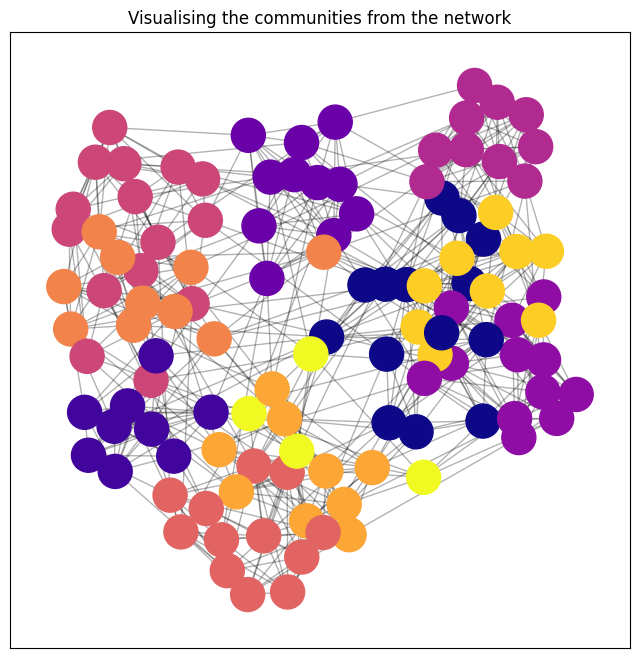

Best partition: [[0, 4, 9, 11, 16, 23, 24, 28, 41, 50, 69, 90, 93, 104], [1, 25, 33, 37, 45, 89, 103, 105, 109], [2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106], [3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107], [7, 8, 21, 22, 51, 68, 77, 78, 108, 111], [12, 14, 18, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 85, 99], [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113], [19, 29, 30, 35, 55, 79, 80, 82, 94, 101], [44, 48, 57, 66, 75, 86, 91, 92, 112], [46, 49, 53, 67, 73, 83, 88, 110, 114], [58, 59, 63, 97]]
Best modularity: 0.6045695626834571
-----------------------------------------------------------------------------------------------------------------------------------------------
The current graph is:  Graph with 34 nodes and 78 edges


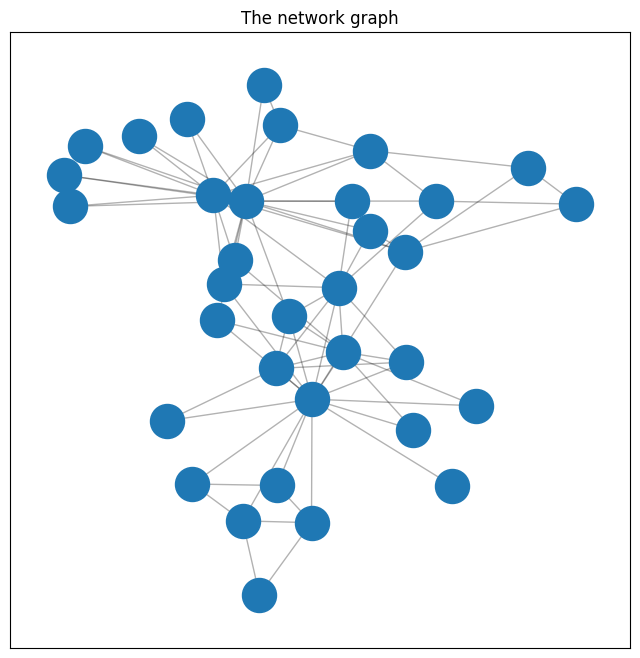

Generation 1, Best Fitness: 0.017340565417488497
Generation 2, Best Fitness: 0.3896285338593031
Generation 3, Best Fitness: 0.405982905982906
Generation 4, Best Fitness: 0.405982905982906
Generation 5, Best Fitness: 0.41978961209730437
Generation 6, Best Fitness: 0.41978961209730437
Generation 7, Best Fitness: 0.41978961209730437
Generation 8, Best Fitness: 0.41978961209730437
Generation 9, Best Fitness: 0.41978961209730437
Generation 10, Best Fitness: 0.41978961209730437
No improvement for 10 generations. Stopping early.


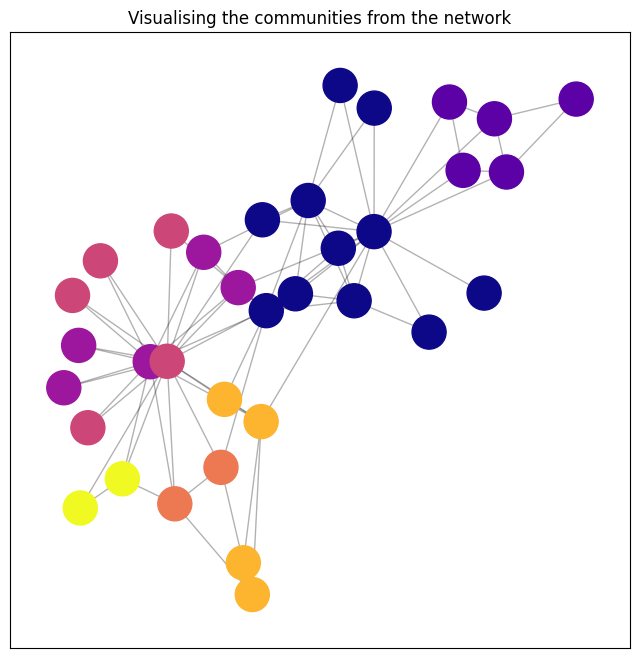

Best partition: [[1, 2, 3, 4, 8, 12, 13, 14, 18, 20, 22], [5, 6, 7, 11, 17], [9, 19, 23, 31, 33], [10, 15, 16, 21, 34], [24, 28], [25, 26, 29, 32], [27, 30]]
Best modularity: 0.41978961209730437
-----------------------------------------------------------------------------------------------------------------------------------------------
The current graph is:  Graph with 105 nodes and 441 edges


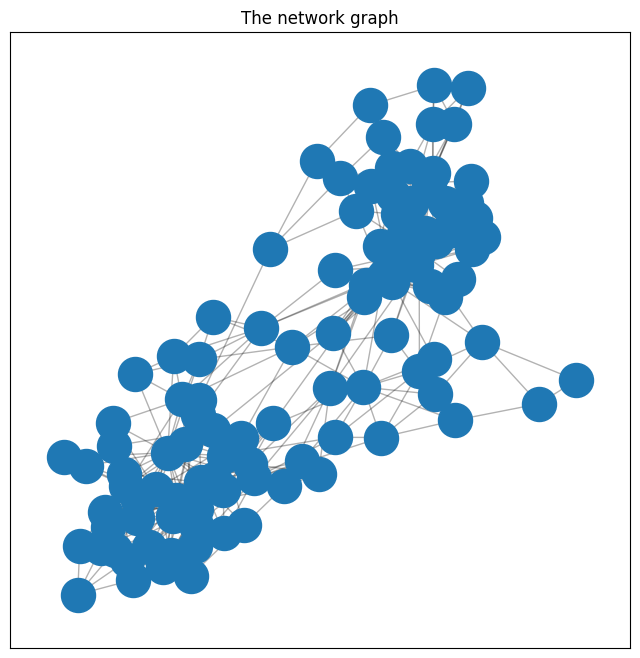

Generation 1, Best Fitness: 0.003928404317131239
Generation 2, Best Fitness: 0.45023678405602596
Generation 3, Best Fitness: 0.5017533846494002
Generation 4, Best Fitness: 0.5022110129010032
Generation 5, Best Fitness: 0.5259022732297757
Generation 6, Best Fitness: 0.5259022732297757
Generation 7, Best Fitness: 0.5259022732297757
Generation 8, Best Fitness: 0.5259022732297757
Generation 9, Best Fitness: 0.5259022732297757
Generation 10, Best Fitness: 0.5259022732297757
No improvement for 10 generations. Stopping early.


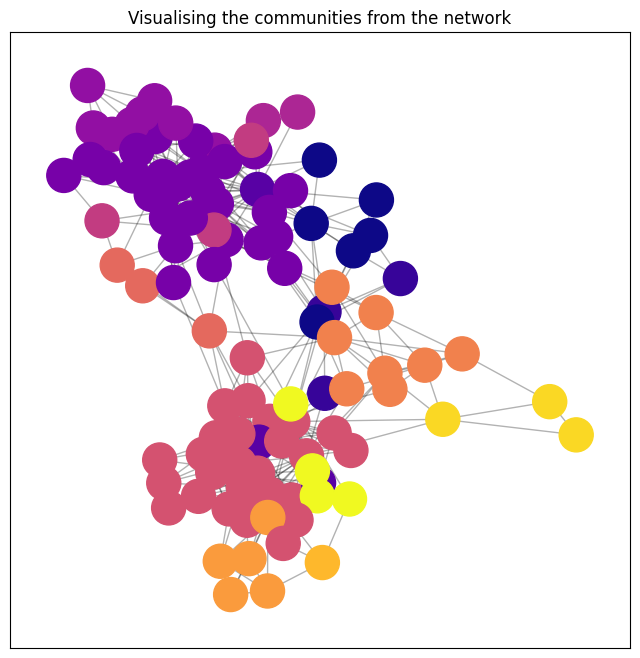

Best partition: [[0, 1, 5, 6, 7, 18], [2, 4, 28], [3, 72, 90], [8, 9, 11, 12, 13, 14, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 40, 41, 42, 43, 44, 45, 46, 47, 50, 53, 54], [10, 33, 34, 35, 36, 37, 38, 39], [15, 16], [19, 55, 56], [30, 31, 66, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 96, 97, 98, 100, 101], [48, 49, 57], [51, 52, 58, 64, 65, 68, 69, 85], [59, 60, 62, 63, 99], [61], [67, 103, 104], [93, 94, 95, 102]]
Best modularity: 0.5259022732297757
-----------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
def main():
    crtDir = os.getcwd()

    filePaths = [
        os.path.join(crtDir, 'data', 'real-networks', 'dolphins', 'dolphins.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'football', 'football.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'karate', 'karate.gml'),
        os.path.join(crtDir, 'data', 'real-networks', 'krebs', 'krebs.gml')
    ]

    for filePath in filePaths:
        G = readNetGML(filePath)
        print("The current graph is: ", G)
        plotNetwork(G)
        
        best_partition, best_modularity = genetic_algorithm_community_detection(G)
        plotCommunities(G, nx.spring_layout(G), individual_to_communities(best_partition))
        
        print("Best partition:", individual_to_communities(best_partition))
        print("Best modularity:", best_modularity)
        
        print("-----------------------------------------------------------------------------------------------------------------------------------------------")

main()

The current graph is:  Graph with 115 nodes and 613 edges


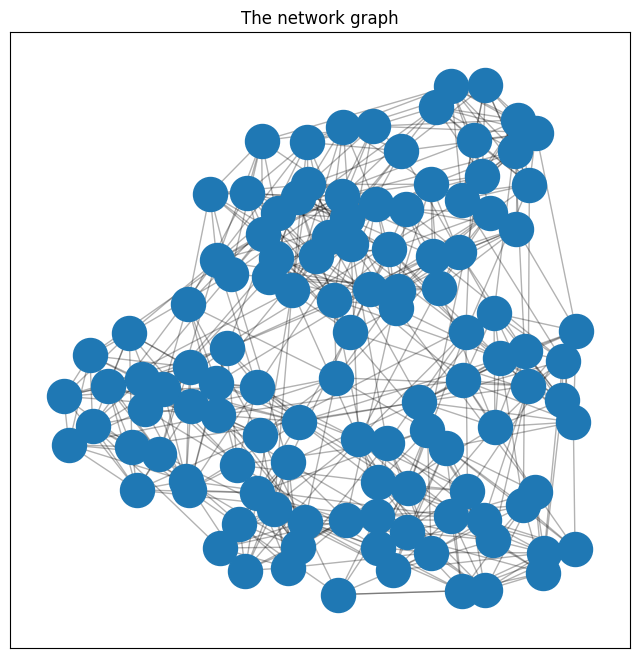

Generation 1, Best Fitness: 0.00037523052726542186
Generation 2, Best Fitness: 0.010588952255241929
Generation 3, Best Fitness: 0.010588952255241929
Generation 4, Best Fitness: 0.010588952255241929
Generation 5, Best Fitness: 0.010588952255241929


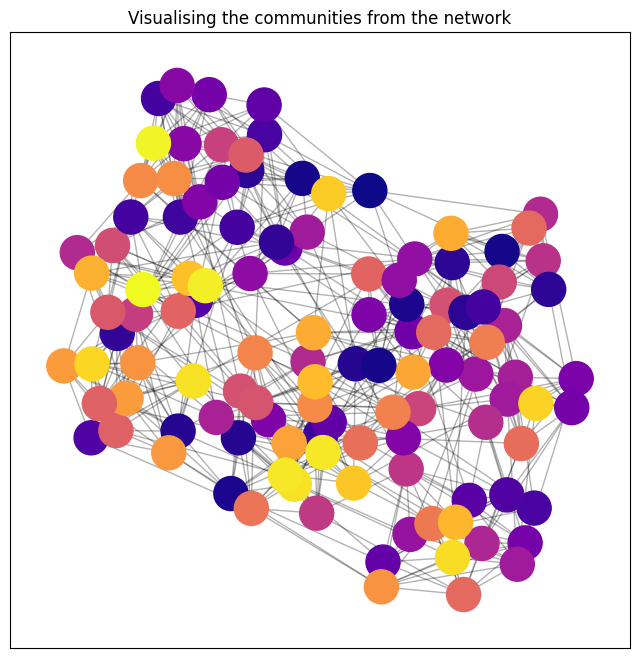

Best partition: [[0], [1, 50, 96], [2, 65], [3, 15, 91], [4, 89, 95, 109], [5, 69], [6], [7], [8, 67, 101, 104], [9, 42], [10, 43], [11], [12], [13, 23], [14], [16], [17], [18, 78, 79, 90], [19], [20, 32], [21, 56, 57], [22, 108], [24], [25, 113], [26], [27], [28, 34, 35], [29], [30, 97], [31], [33, 58, 73], [36], [37], [38], [39], [40], [41], [44], [45], [46], [47, 70], [48], [49], [51], [52, 107], [53, 87], [54, 80, 105], [55], [59], [60], [61], [62], [63], [64], [66, 77], [68], [71, 81], [72], [74, 84], [75], [76], [82, 103], [83], [85], [86], [88], [92], [93], [94], [98], [99], [100, 102], [106, 112], [110], [111], [114]]
Best modularity: 0.010588952255241929
-----------------------------------------------------------------------------------------------------------------------------------------------
The current graph is:  Graph with 77 nodes and 254 edges


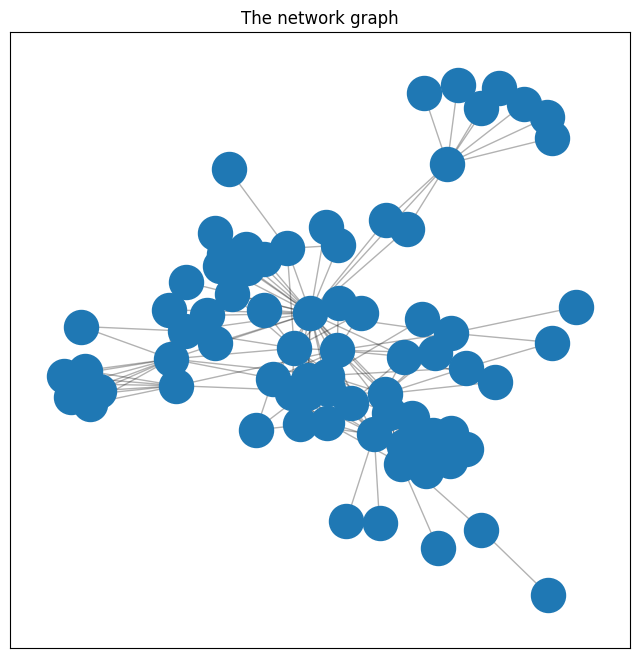

Generation 1, Best Fitness: -0.006649513299026602
Generation 2, Best Fitness: 0.0002712505425010825
Generation 3, Best Fitness: 0.0002712505425010825
Generation 4, Best Fitness: 0.009369768739537473
Generation 5, Best Fitness: 0.011997023994047977


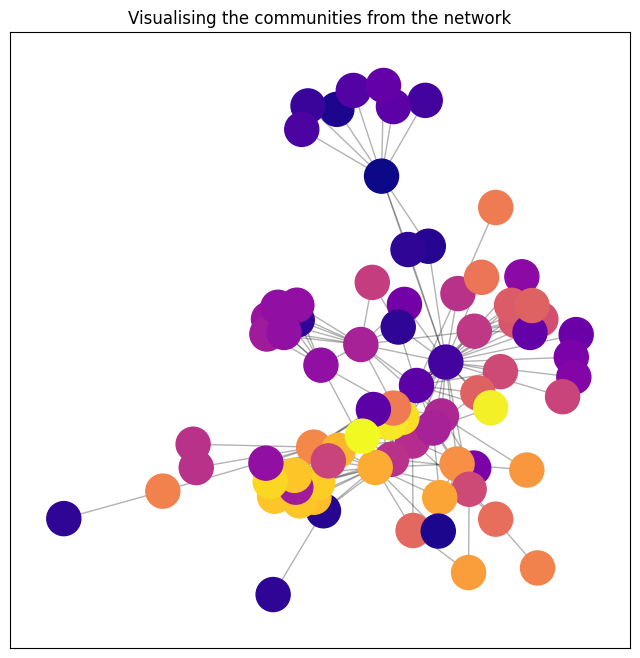

Best partition: [[0], [1, 56], [2, 57], [3, 19, 31, 46, 67], [4], [5, 11], [6], [7], [8, 27, 71], [9, 37], [10], [12], [13, 42], [14], [15], [16, 20, 21, 22, 76], [17], [18, 63], [23, 26], [24], [25], [28, 41, 73, 74], [29], [30], [32, 64], [33, 51], [34], [35], [36], [38, 43], [39], [40], [44], [45, 70], [47, 53], [48], [49], [50], [52], [54], [55], [58], [59], [60, 61, 65], [62], [66], [68], [69], [72], [75]]
Best modularity: 0.011997023994047977
-----------------------------------------------------------------------------------------------------------------------------------------------
The current graph is:  Graph with 4941 nodes and 6594 edges


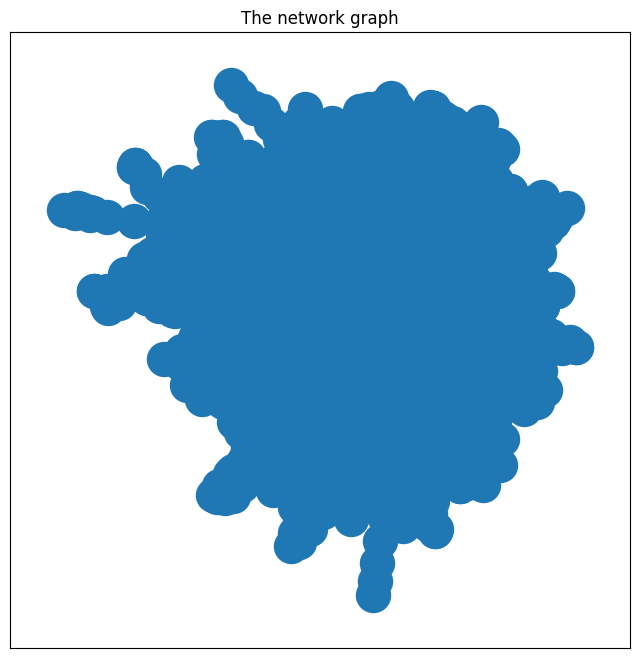

Generation 1, Best Fitness: 0.00026371388075427024
Generation 2, Best Fitness: 0.00026371388075427024
Generation 3, Best Fitness: 0.00040790384067132524
Generation 4, Best Fitness: 0.000419828634389642
Generation 5, Best Fitness: 0.0007188799221799626


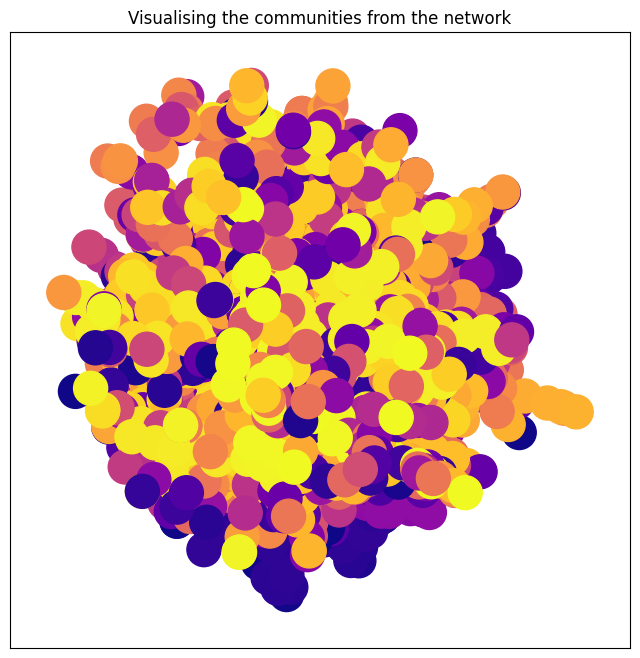

Best partition: [[0, 612], [1], [2], [3], [4, 3726, 4685], [5, 1837], [6, 1407, 2170], [7, 4152], [8, 1199], [9, 4445], [10], [11, 223, 3375], [12, 3273, 3958], [13, 4762], [14], [15], [16, 785], [17, 2204], [18], [19, 3405, 3999], [20], [21, 574, 1580, 2081], [22], [23, 1686, 2361], [24], [25, 1297, 2637, 4308], [26, 2111], [27, 2113, 2616, 3224], [28], [29, 154, 700], [30], [31], [32, 1325], [33], [34, 2783, 3777], [35, 515], [36, 3021], [37, 2737, 3961], [38], [39, 49, 2587], [40], [41], [42, 2656], [43, 103, 1163, 1872], [44, 1846], [45, 4557, 4821], [46, 1815], [47, 3648, 3790], [48], [50, 643, 3942], [51, 1329, 3122], [52, 1775], [53, 3870, 4413], [54], [55, 445, 1680], [56], [57], [58, 635], [59], [60, 573], [61, 4096], [62], [63], [64, 3302, 4499], [65, 4709], [66], [67], [68, 3960], [69], [70], [71, 584], [72, 3488, 3988], [73, 4289], [74], [75, 2687], [76], [77, 3386, 4570], [78], [79, 2025], [80, 3291], [81, 4393], [82, 2222], [83], [84], [85], [86], [87, 2653], [88, 1475, 2

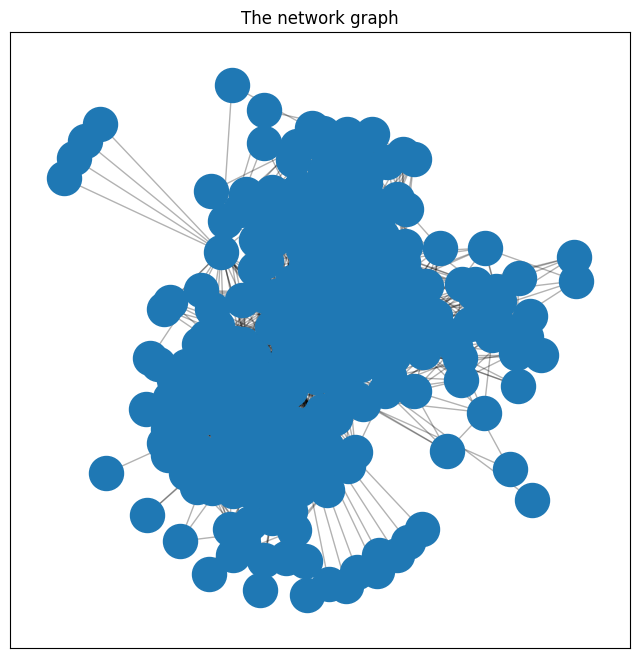

Generation 1, Best Fitness: -0.002519666642392213
Generation 2, Best Fitness: -0.002519666642392213
Generation 3, Best Fitness: -0.001984436607263611
Generation 4, Best Fitness: -0.00041678370421231156
Generation 5, Best Fitness: -0.00041678370421231156


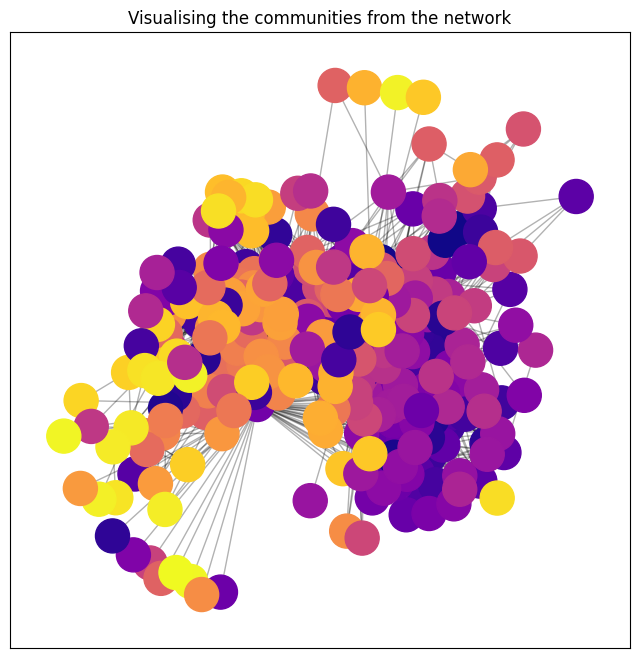

Best partition: [[0], [1, 10, 122], [2, 109], [3, 50], [4], [5, 269], [6, 35], [7], [8, 105, 153, 192], [9, 46, 265], [11, 54, 225], [12, 287], [13, 98, 184], [14], [15], [16, 219], [17, 42, 135, 196], [18, 154, 186], [19], [20, 62, 176], [21, 49, 218, 230, 266], [22, 87], [23], [24, 115, 118], [25], [26], [27], [28, 201, 270], [29, 254], [30], [31, 128], [32, 155], [33, 86, 147], [34], [36], [37, 38], [39, 113], [40, 209, 290], [41], [43, 129, 190], [44], [45, 67, 198], [47], [48], [51], [52], [53, 221, 261, 286], [55, 237], [56, 71], [57], [58], [59, 106, 257], [60, 142, 226], [61, 125, 149], [63], [64, 94, 116], [65], [66], [68, 242], [69], [70, 95], [72, 236], [73, 114, 130], [74, 103, 141, 195], [75], [76, 146], [77], [78, 172, 262], [79], [80], [81], [82], [83, 263], [84, 138], [85], [88, 248, 284], [89], [90], [91, 127], [92, 255], [93], [96, 179, 224, 280], [97], [99], [100], [101, 247], [102], [104, 131, 285], [107], [108, 110], [111], [112, 223, 239], [117], [119], [120, 175]

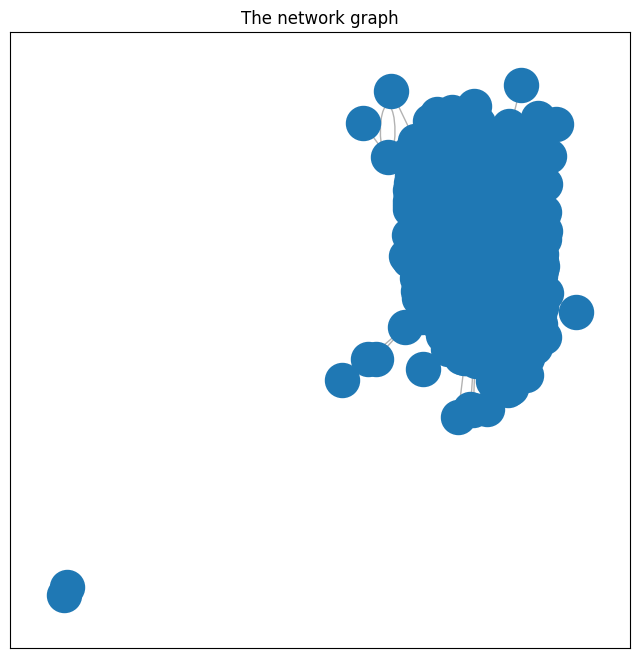

Generation 1, Best Fitness: -0.001533033967785011
Generation 2, Best Fitness: -0.0012921769319916812
Generation 3, Best Fitness: -0.0012921769319916812
Generation 4, Best Fitness: -0.0012921769319916812
Generation 5, Best Fitness: -0.0010524809331963838


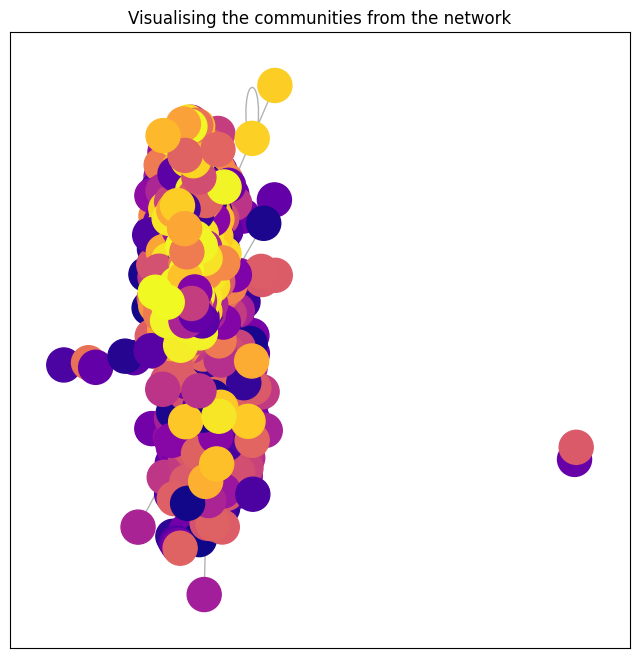

Best partition: [[1, 416, 1262, 1264], [2], [5, 776, 951], [6, 317, 397], [7], [8, 229, 729, 962], [9], [10, 661, 758], [11, 85], [12], [13, 1214], [14], [15, 187, 502, 508, 1131, 1160], [16], [17], [18, 444, 747, 1244], [19], [20, 1046], [21, 577, 1402], [22, 601], [23, 333, 854], [24], [26], [27], [28, 1177], [29], [30], [31], [32], [33, 1020, 1213], [34, 1209], [35, 1135, 1183], [36, 511, 527, 1148], [37, 858], [38], [39, 850], [40, 193], [41], [42], [43, 622], [44], [45, 947], [46, 760, 763], [47], [51, 391], [52, 171, 842, 1208], [53, 1306], [55, 754], [56, 803], [58, 494], [59], [62, 367, 675, 1124], [64], [65], [66, 745], [67], [68, 301], [69], [70, 192, 466, 713], [72, 512], [73, 1168, 1179, 1404], [75, 800, 1254], [76], [77, 312, 1222], [78], [79, 943, 1061], [80, 635, 1274, 1329], [81, 838, 1337], [82, 1075], [83, 539], [84], [86], [87, 687], [88], [89], [90, 1194, 1238, 1468], [92, 1139], [93, 1140], [95], [96], [97], [98, 873], [99, 972], [100, 132], [101], [102, 691, 722],

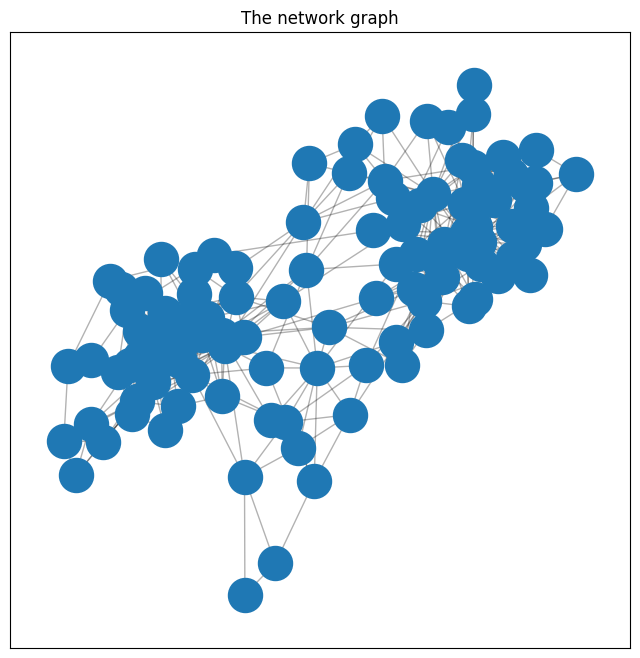

Generation 1, Best Fitness: -0.0027226310025143825
Generation 2, Best Fitness: -0.0027226310025143825
Generation 3, Best Fitness: 0.00375100909600424
Generation 4, Best Fitness: 0.00375100909600424
Generation 5, Best Fitness: 0.007208930435363868


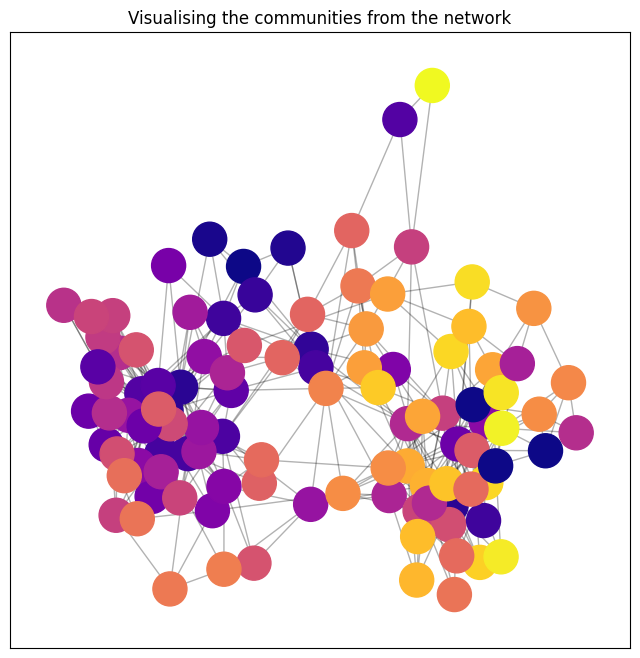

Best partition: [[0, 62, 86, 100], [1], [2], [3, 8, 74], [4], [5], [6, 88], [7, 11, 13], [9], [10, 104], [12, 39], [14], [15], [16, 41, 73], [17], [18], [19, 28], [20], [21, 81], [22], [23, 26, 49], [24], [25], [27, 101], [29, 31], [30, 82], [32, 33, 63], [34], [35], [36], [37, 43, 66, 67], [38, 45, 75], [40], [42, 79], [44, 48], [46], [47, 84], [50], [51, 52, 69], [53, 90, 91], [54], [55, 92], [56, 65], [57], [58], [59], [60, 76, 77], [61], [64], [68, 102], [70, 96], [71], [72], [78], [80, 94], [83], [85], [87], [89, 93], [95], [97], [98], [99], [103]]
Best modularity: 0.007208930435363868
-----------------------------------------------------------------------------------------------------------------------------------------------


In [15]:
def main():
    crtDir = os.getcwd()

    filePaths = [
        os.path.join(crtDir, 'data', 'my-networks', 'football', 'football.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'lesmis', 'lesmis.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'power', 'power.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'celegansneural', 'celegansneural.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'polblogs', 'polblogs.gml'),
        os.path.join(crtDir, 'data', 'my-networks', 'polbooks', 'polbooks.gml')
    ]

    for filePath in filePaths:
        G = readNetGML(filePath)
        print("The current graph is: ", G)
        plotNetwork(G)
        
        best_partition, best_modularity = genetic_algorithm_community_detection(G)
        plotCommunities(G, nx.spring_layout(G), individual_to_communities(best_partition))
        
        print("Best partition:", individual_to_communities(best_partition))
        print("Best modularity:", best_modularity)
        
        print("-----------------------------------------------------------------------------------------------------------------------------------------------")

main()